## Installing PyTorch Environment

In [13]:
%pip install torch torchvision torchaudio
%pip install pandas
%pip install scikit-learn
%pip install xlrd
%pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Training Overfit models...
  ➤ Run 1/10
  ➤ Run 2/10
  ➤ Run 3/10
  ➤ Run 4/10
  ➤ Run 5/10
  ➤ Run 6/10
  ➤ Run 7/10
  ➤ Run 8/10
  ➤ Run 9/10
  ➤ Run 10/10

Training Dropout models...
  ➤ Run 1/10
  ➤ Run 2/10
  ➤ Run 3/10
  ➤ Run 4/10
  ➤ Run 5/10
  ➤ Run 6/10
  ➤ Run 7/10
  ➤ Run 8/10
  ➤ Run 9/10
  ➤ Run 10/10


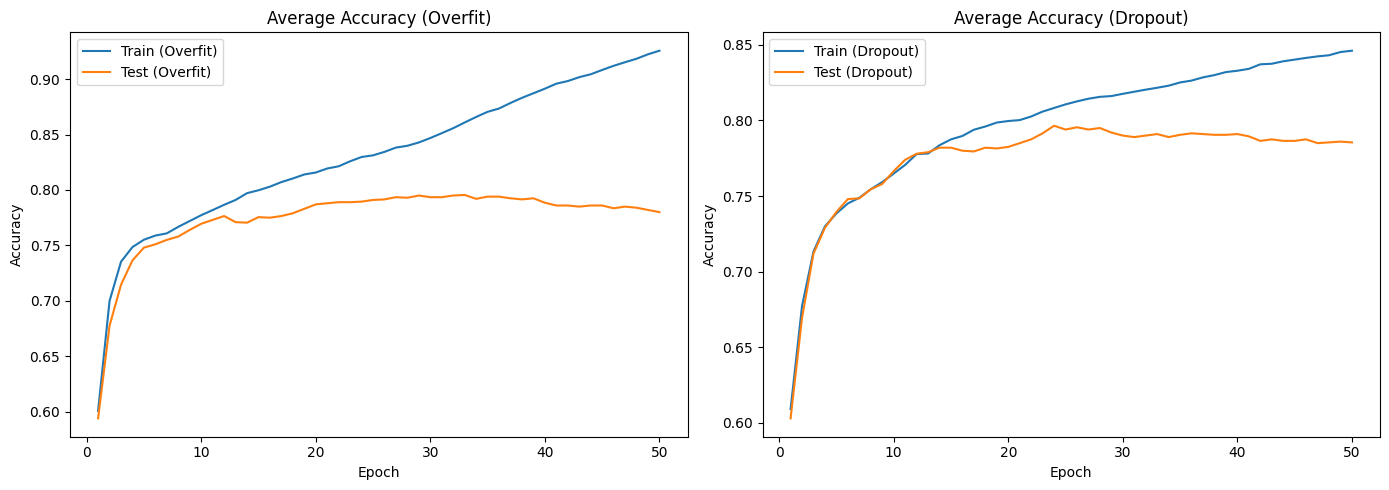

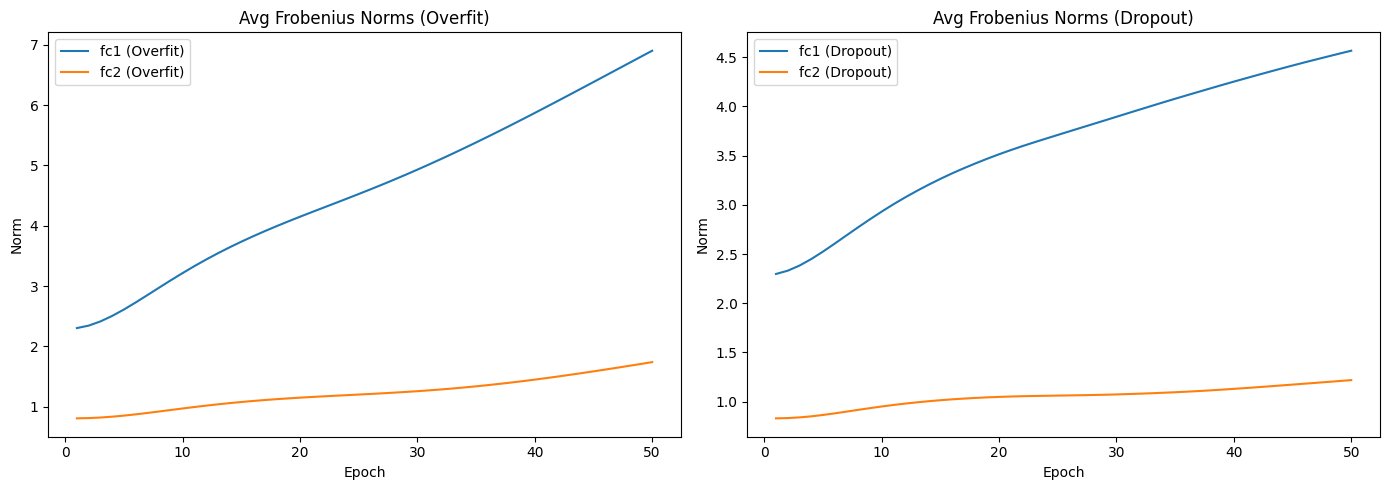

In [ ]:
column_names = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount',
    'Savings', 'Employment', 'InstallmentRate', 'PersonalStatusSex',
    'OtherDebtors', 'ResidenceDuration', 'Property', 'Age', 'OtherInstallmentPlans',
    'Housing', 'ExistingCredits', 'Job', 'NumLiablePeople', 'Telephone', 'ForeignWorker',
    'Target'
]

df = pd.read_csv('german.data', sep=' ', names=column_names)
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)
df['Target'] = df['Target'] - 1

X = df.drop(columns='Target').values
y = df['Target'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

# Define models
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=2, dropout=False):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) if dropout else nn.Identity()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == y).sum().item()
        total = y.size(0)
    model.train()
    return correct / total

def compute_layerwise_frobenius_norm(model):
    norms = {}
    norms['fc1'] = torch.norm(model.fc1.weight.data, p='fro').item()
    norms['fc2'] = torch.norm(model.fc2.weight.data, p='fro').item()
    return norms

def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    train_accs = []
    test_accs = []
    layerwise_norms = {'fc1': [], 'fc2': []}

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))

        layer_norms = compute_layerwise_frobenius_norm(model)
        for layer in layerwise_norms:
            layerwise_norms[layer].append(layer_norms[layer])

    return model, losses, train_accs, test_accs, layerwise_norms

input_size = X_train.shape[1]

import numpy as np

def average_over_runs(model_type, input_size, dropout, runs=10, epochs=1000):
    all_train_accs = []
    all_test_accs = []
    all_fc1_norms = []
    all_fc2_norms = []

    print(f"\nTraining {model_type} models...")
    for i in range(runs):
        print(f"  ➤ Run {i+1}/{runs}")
        model = TwoLayerNN(input_size, dropout=dropout)
        _, _, train_accs, test_accs, norms = train_model(
            model, X_train_tensor, y_train_tensor,
            X_test_tensor, y_test_tensor,
            epochs=epochs
        )
        all_train_accs.append(train_accs)
        all_test_accs.append(test_accs)
        all_fc1_norms.append(norms['fc1'])
        all_fc2_norms.append(norms['fc2'])

    return {
        'mean_train_acc': np.mean(all_train_accs, axis=0),
        'mean_test_acc': np.mean(all_test_accs, axis=0),
        'mean_fc1_norm': np.mean(all_fc1_norms, axis=0),
        'mean_fc2_norm': np.mean(all_fc2_norms, axis=0),
    }

# ⏳ Run for both model types
epochs = 50
overfit_stats = average_over_runs("Overfit", input_size, dropout=False, runs=10, epochs=epochs)
dropout_stats = average_over_runs("Dropout", input_size, dropout=True, runs=10, epochs=epochs)


# Accuracy plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), overfit_stats['mean_train_acc'], label='Train (Overfit)')
plt.plot(range(1, epochs+1), overfit_stats['mean_test_acc'], label='Test (Overfit)')
plt.title('Average Accuracy (Overfit)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), dropout_stats['mean_train_acc'], label='Train (Dropout)')
plt.plot(range(1, epochs+1), dropout_stats['mean_test_acc'], label='Test (Dropout)')
plt.title('Average Accuracy (Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Frobenius norm plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), overfit_stats['mean_fc1_norm'], label='fc1 (Overfit)')
plt.plot(range(1, epochs+1), overfit_stats['mean_fc2_norm'], label='fc2 (Overfit)')
plt.title('Avg Frobenius Norms (Overfit)')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), dropout_stats['mean_fc1_norm'], label='fc1 (Dropout)')
plt.plot(range(1, epochs+1), dropout_stats['mean_fc2_norm'], label='fc2 (Dropout)')
plt.title('Avg Frobenius Norms (Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.legend()
plt.tight_layout()
plt.show()


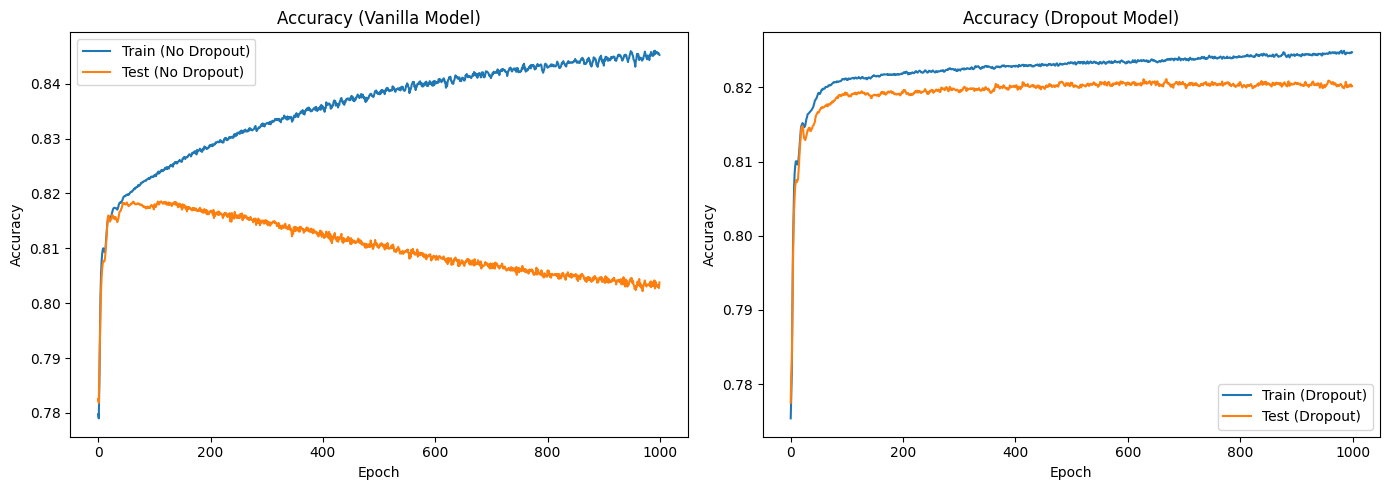

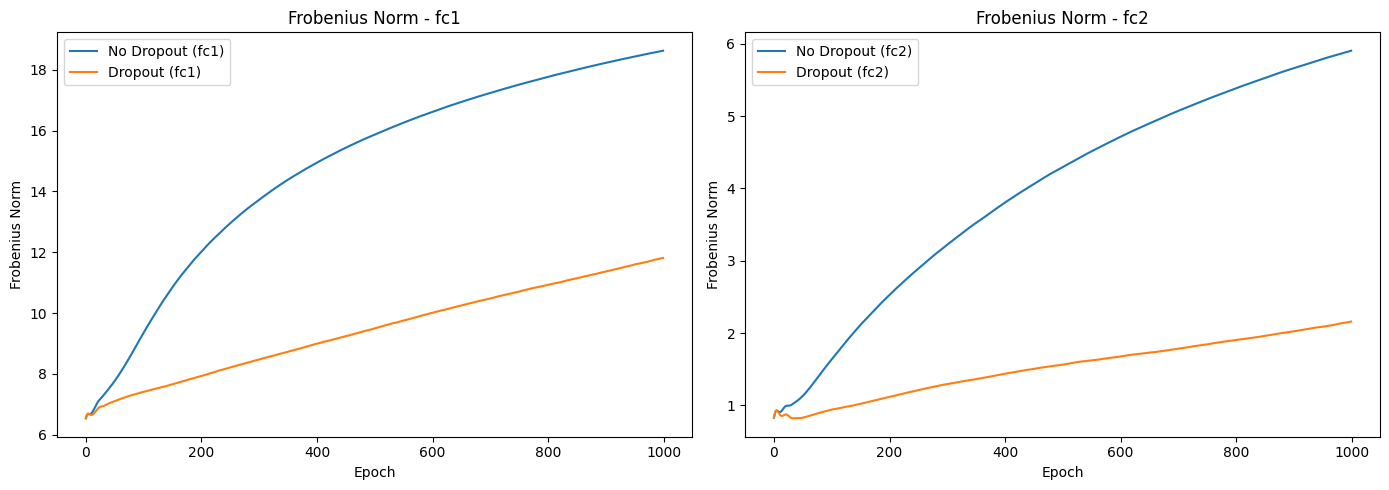

In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_excel('default of credit card clients.xls', header=1)
df = df.drop(columns='ID')
df.rename(columns={'default payment next month': 'default'}, inplace=True)

# Preprocessing
X = df.drop(columns='default').values
y = df['default'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

# Original model (overfitting likely)
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Dropout-regularized model
class TwoLayerDropoutNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2, dropout_rate=0.5):
        super(TwoLayerDropoutNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == y).sum().item()
        total = y.size(0)
    model.train()
    return correct / total

def compute_layerwise_frobenius_norm(model):
    return {
        'fc1': torch.norm(model.fc1.weight.data, p='fro').item(),
        'fc2': torch.norm(model.fc2.weight.data, p='fro').item()
    }

def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    train_accs = []
    test_accs = []
    layerwise_norms = {'fc1': [], 'fc2': []}

    for _ in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))

        norms = compute_layerwise_frobenius_norm(model)
        for layer in norms:
            layerwise_norms[layer].append(norms[layer])

    return losses, train_accs, test_accs, layerwise_norms

def average_training(model_class, input_size, epochs, num_runs=10, dropout=False):
    all_train_accs = []
    all_test_accs = []
    all_fc1_norms = []
    all_fc2_norms = []

    for _ in range(num_runs):
        if dropout:
            model = model_class(input_size)
        else:
            model = model_class(input_size)
        _, train_accs, test_accs, norms = train_model(
            model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=epochs
        )
        all_train_accs.append(train_accs)
        all_test_accs.append(test_accs)
        all_fc1_norms.append(norms['fc1'])
        all_fc2_norms.append(norms['fc2'])

    return {
        'mean_train_acc': np.mean(all_train_accs, axis=0),
        'mean_test_acc': np.mean(all_test_accs, axis=0),
        'mean_fc1_norm': np.mean(all_fc1_norms, axis=0),
        'mean_fc2_norm': np.mean(all_fc2_norms, axis=0),
    }

# === Run experiments ===
input_size = X_train.shape[1]
epochs = 1000  # enough to cause overfitting in the vanilla model

# Overfitting model (no dropout)
vanilla_stats = average_training(TwoLayerNN, input_size, epochs=epochs, num_runs=10)

# Regularized model (dropout)
dropout_stats = average_training(lambda input_size: TwoLayerDropoutNN(input_size), input_size, epochs=epochs, num_runs=10, dropout=True)

# === Plotting ===
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(vanilla_stats['mean_train_acc'], label='Train (No Dropout)')
plt.plot(vanilla_stats['mean_test_acc'], label='Test (No Dropout)')
plt.title('Accuracy (Vanilla Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dropout_stats['mean_train_acc'], label='Train (Dropout)')
plt.plot(dropout_stats['mean_test_acc'], label='Test (Dropout)')
plt.title('Accuracy (Dropout Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
for i, layer in enumerate(['fc1', 'fc2']):
    plt.subplot(1, 2, i+1)
    plt.plot(vanilla_stats[f'mean_{layer}_norm'], label=f'No Dropout ({layer})')
    plt.plot(dropout_stats[f'mean_{layer}_norm'], label=f'Dropout ({layer})')
    plt.title(f'Frobenius Norm - {layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Frobenius Norm')
    plt.legend()
plt.tight_layout()
plt.show()


🔴 Overfitting group (no dropout)...

🟢 Regularized group (with dropout)...


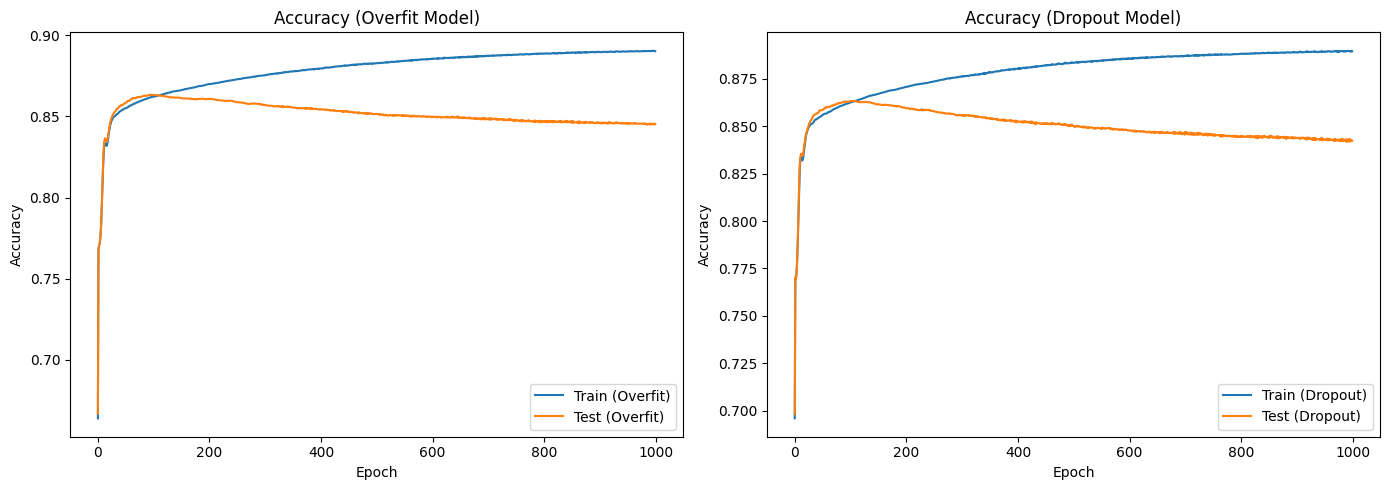

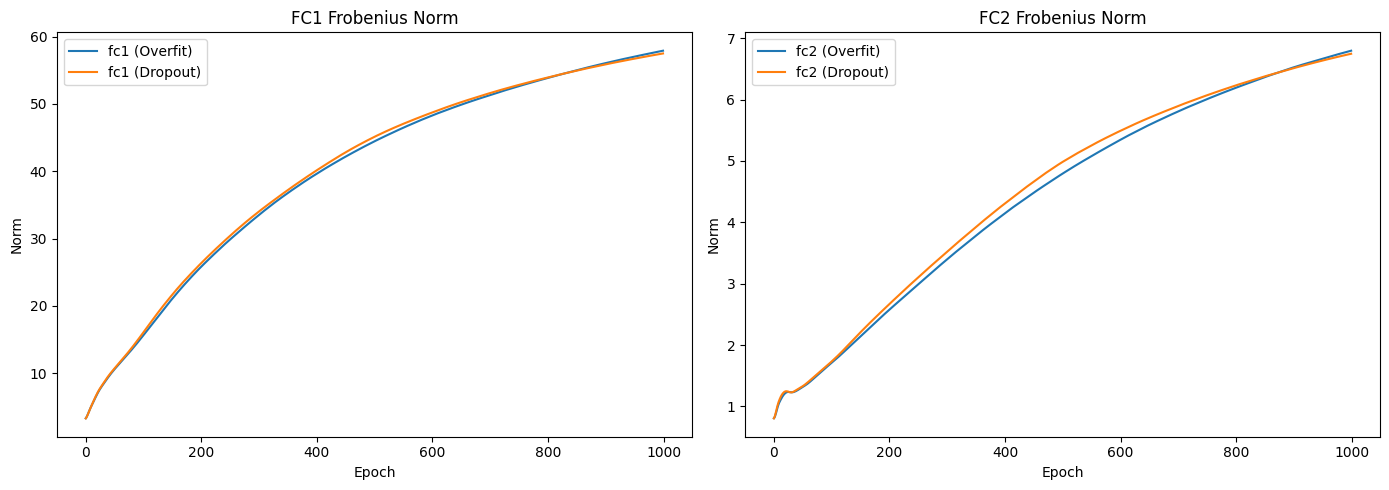

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load and preprocess data
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                 names=column_names, na_values=" ?", skipinitialspace=True)
df.dropna(inplace=True)

X = df.drop("income", axis=1)
y = (df["income"] == ">50K").astype(int)

categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])
X_processed = preprocessor.fit_transform(X)

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train_np.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.long)

# Model with optional dropout
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout=False):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) if dropout else nn.Identity()
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1)
        return (preds == y).float().mean().item()

def compute_layerwise_frobenius_norm(model):
    return {
        'fc1': torch.norm(model.fc1.weight.data, p='fro').item(),
        'fc2': torch.norm(model.fc2.weight.data, p='fro').item()
    }

def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accs, test_accs = [], []
    layerwise_norms = {'fc1': [], 'fc2': []}

    for _ in range(epochs):
        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))

        norms = compute_layerwise_frobenius_norm(model)
        for layer in norms:
            layerwise_norms[layer].append(norms[layer])

    return train_accs, test_accs, layerwise_norms

def average_training(input_size, dropout=False, num_runs=10, epochs=1000):
    all_train_accs = []
    all_test_accs = []
    all_fc1_norms = []
    all_fc2_norms = []

    for _ in range(num_runs):
        model = TwoLayerNN(input_size, dropout=dropout)
        train_accs, test_accs, norms = train_model(
            model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=epochs)
        all_train_accs.append(train_accs)
        all_test_accs.append(test_accs)
        all_fc1_norms.append(norms['fc1'])
        all_fc2_norms.append(norms['fc2'])

    return {
        'train': np.mean(all_train_accs, axis=0),
        'test': np.mean(all_test_accs, axis=0),
        'fc1': np.mean(all_fc1_norms, axis=0),
        'fc2': np.mean(all_fc2_norms, axis=0),
    }

# Run training
input_size = X_train_tensor.shape[1]
print("🔴 Overfitting group (no dropout)...")
stats_overfit = average_training(input_size, dropout=False)

print("\n🟢 Regularized group (with dropout)...")
stats_dropout = average_training(input_size, dropout=True)

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(stats_overfit['train'], label="Train (Overfit)")
plt.plot(stats_overfit['test'], label="Test (Overfit)")
plt.title("Accuracy (Overfit Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stats_dropout['train'], label="Train (Dropout)")
plt.plot(stats_dropout['test'], label="Test (Dropout)")
plt.title("Accuracy (Dropout Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Frobenius Norms
plt.figure(figsize=(14, 5))
for i, layer in enumerate(["fc1", "fc2"]):
    plt.subplot(1, 2, i + 1)
    plt.plot(stats_overfit[layer], label=f"{layer} (Overfit)")
    plt.plot(stats_dropout[layer], label=f"{layer} (Dropout)")
    plt.title(f"{layer.upper()} Frobenius Norm")
    plt.xlabel("Epoch")
    plt.ylabel("Norm")
    plt.legend()
plt.tight_layout()
plt.show()
